# TV Minimization


In this example $Y=AX+N$ simulation enviroment will be created.
In this equation:
- Y is the observation
- A is system geometry parameters
- X is varible (the thing which is observed )
- N is randomly distrubuted zero mean gaussian noise

Size of this vector and matrices are:
$$ Y_{mx1}=A_{mxn}X_{nx1} + N_{mx1} $$


now contiune with code.


## 1. Configuration

### Import libraries


In [1]:

import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline 

plt.rcParams['figure.figsize'] = [16, 10]
plt.gray()


<Figure size 1152x720 with 0 Axes>

### Helper functions

In [2]:

def normalize(a):
    return a/255

def denormalize(a):
    return a*255

# image to matrix
def i2m(a):
    return np.array(a)/255

# matrix to image
def m2i(a):
    return Image.fromarray(a*255).convert("L")


### Params

In [3]:
EPS = 0.0000000001 # epsilon
BETA =  0.2 #
LEARNING_RATE = 0.001

## 2. Init

To simulate the problem the following equation is defined

$ Y = X + N $

where:
- X is the real & non-noisy image ( It is the varible which should be estimated )
- N is random gaussion noise
- Y is the observation


In [4]:
Xreal = i2m(  Image.open('test/phantom.png').convert('L').resize((600,600), Image.ANTIALIAS) )
pixelSizeX, pixelSizeY = np.shape(Xreal)
noise = np.random.rand(pixelSizeX, pixelSizeY) * 0.2

Y = Xreal + noise

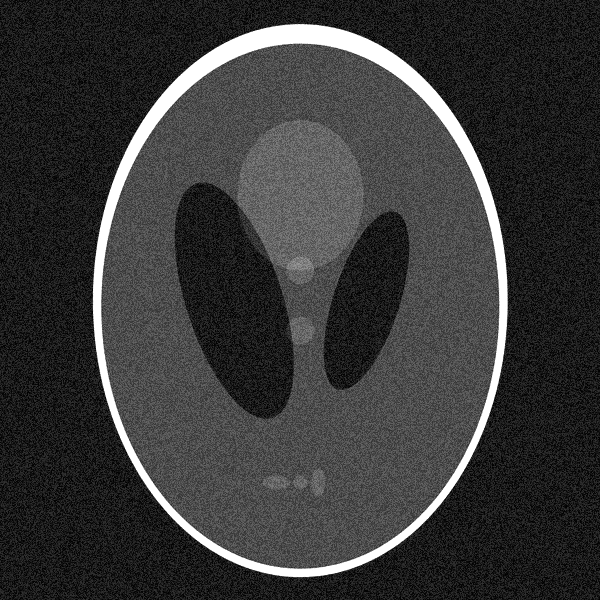

In [5]:
m2i(Y)

## 3. TV

### Define TV

Tv

$
T V_{2 D}(X)=\sum_{i}^{K} \sum_{j}^{L} \sqrt{\left(X_{i, j}-X_{i-1, j}\right)^{2}+\left(X_{i, j}-X_{i, j-1}\right)^{2}}
$

Gradient of tv

$Grad(X)=\frac{2\left(X_{i, j}-X_{i-1, j}\right)+2\left(X_{i j}-X_{i j-1}\right)}{\sqrt{\left(X_{i, j}-X_{i-1, j}\right)^{2}+\left(X_{i, j}-X_{i, j-1}\right)^{2}+\varepsilon}}
-\frac{2\left(X_{i+1, j}-X_{i, j}\right)}{\sqrt{\left(X_{i+1, j}-X_{i, j}\right)^{2}+\left(X_{i+1, j}-X_{i+1, j-1}\right)^{2}+\varepsilon}}
-\frac{2\left(X_{i, j+1}-X_{i, j}\right)}{\sqrt{\left(X_{i, j+1}-X_{i, j}\right)^{2}+\left(X_{i, j+1}-X_{i-1, j+1}\right)^{2}+\varepsilon}}
$

### Classic TV

In [6]:
def tvNorm(x):
    """Computes the total variation norm and its gradient. From jcjohnson/cnn-vis."""
    x_diff = x - np.roll(x, -1, axis=1)
    y_diff = x - np.roll(x, -1, axis=0)
    grad_norm2 = x_diff**2 + y_diff**2 + EPS
    norm = np.sum(np.sqrt(grad_norm2))
    return norm

def tvGrad(x):
    """Computes the total variation norm and its gradient. From jcjohnson/cnn-vis."""
    x_diff = x - np.roll(x, -1, axis=1)
    y_diff = x - np.roll(x, -1, axis=0)
    grad_norm2 = x_diff**2 + y_diff**2 + EPS
    dgrad_norm = 0.5 / np.sqrt(grad_norm2)
    dx_diff = 2 * x_diff * dgrad_norm
    dy_diff = 2 * y_diff * dgrad_norm
    grad = dx_diff + dy_diff
    grad[:, 1:] -= dx_diff[:, :-1]
    grad[1:, :] -= dy_diff[:-1, :]
    return grad


def l2Norm(x):
    """Computes 1/2 the square of the L2-norm and its gradient."""
    return np.sum(x**2) / 2

def l2NormGrad(x):
    return x


### Directional TV

In [7]:
def directionalTVNorm(X):
    M,N = np.shape(X)
    XM = X
    tv = 0
    for i in range(3, M-3):
        for j in range(3, N-3):
            payda1 = (XM[i,j] - XM[i+1,j])**2
            payda2 = (XM[i,j] - XM[i,j+1])**2
            payda3 = (XM[i,j-1] - XM[i,j+2])**2
            tv += sqrt( payda1 + payda2 + payda3 + EPS)
    return tv

def gradA(X):
    M,N = np.shape(X)
    XM = X
    gradX = np.zeros((M,N))
    # XM(4:end-3,4:end-3)=X

    for i in range(3, M-3):
        for j in range(3, N-3):
            pay = 0.5 * -2 * ( XM[i,j-3] - XM[i,j] )
            payda1 = (XM[i,j-2] - XM[i+1,j-2])**2
            payda2 = (XM[i,j-2] - XM[i,j-1])**2
            payda3 = (XM[i,j-3] - XM[i,j])**2
            payda = sqrt( payda1 + payda2 + payda3 + EPS)
            gradX[i,j] = pay / payda
    return gradX



def gradB(X):
    M,N = np.shape(X)
    XM = X
    gradX = np.zeros((M,N))
    # XM(4:end-3,4:end-3)=X

    for i in range(3, M-3):
        for j in range(3, N-3):
            pay = 0.5 * -2 * ( XM[i,j-1] - XM[i,j] )
            payda1 = (XM[i,j-1] - XM[i+1,j-1])**2
            payda2 = (XM[i,j-1] - XM[i,j])**2
            payda3 = (XM[i,j-2] - XM[i,j+1])**2
            payda = sqrt( payda1 + payda2 + payda3 + EPS)
            gradX[i,j] = pay / payda
    return gradX

def gradC(X):
    M,N = np.shape(X)
    XM = X
    gradX = np.zeros((M,N))
    for i in range(3, M-3):
        for j in range(3, N-3):
            pay = 0.5 * 2 * ( XM[i,j] - XM[i+1,j] + XM[i,j] - XM[i,j+1] )
            payda1 = (XM[i,j] - XM[i+1,j])**2
            payda2 = (XM[i,j] - XM[i,j+1])**2
            payda3 = (XM[i,j-1] - XM[i,j+2])**2
            payda = sqrt( payda1 + payda2 + payda3 + EPS)
            gradX[i,j] = pay / payda
    return gradX


def gradD(X):
    M,N = np.shape(X)
    XM = X
    gradX = np.zeros((M,N))
    # XM(4:end-3,4:end-3)=X

    for i in range(3, M-3):
        for j in range(3, N-3):
            pay = 0.5 * 2 * ( XM[i,j] - XM[i,j+3] )
            payda1 = (XM[i,j+1] - XM[i+1,j+1])**2
            payda2 = (XM[i,j+1] - XM[i,j+2])**2
            payda3 = (XM[i,j] - XM[i,j+3])**2
            payda = sqrt( payda1 + payda2 + payda3 + EPS)
            gradX[i,j] = pay / payda
    return gradX


def gradE(X):
    M,N = np.shape(X)
    XM = X
    gradX = np.zeros((M,N))
    # XM(4:end-3,4:end-3)=X

    for i in range(3, M-3):
        for j in range(3, N-3):
            pay = 0.5 * -2 * ( XM[i-1,j] - XM[i,j] )
            payda1 = (XM[i-1,j] - XM[i,j])**2
            payda2 = (XM[i-1,j] - XM[i-1,j+1])**2
            payda3 = (XM[i-1,j-1] - XM[i-1,j+2])**2
            payda = sqrt( payda1 + payda2 + payda3 + EPS)
            gradX[i,j] = pay / payda
    return gradX

def directionalTVGrad(X):
    return gradA(X)+gradB(X)+gradC(X)+gradD(X)+gradE(X)



## 4. Cost functions

### Classic TV

### Define Cost Function

$\hat{X}=\underset{X}{\arg \min }\left[\|Y- X\|_{2}+\beta T V(X)\right]$

In [8]:
def tvCost(Y, X, beta):
    return l2Norm(Y-X) + beta * tvNorm(X)

def tvCostGrad(Y, X, beta):
    return l2NormGrad(Y-X) + beta * tvGrad(X)

### Directional TV

In [9]:
def directionalTVCost(Y, X, beta):
    return l2Norm(Y-X) + beta * directionalTVNorm(X)

def directionalTVCostGrad(Y, X, beta):
    return l2NormGrad(Y-X) + beta * directionalTVGrad(X)

In [ ]:
plt.rcParams['figure.figsize'] = [16, 10]

fig = plt.figure()

ax = fig.add_subplot(121)
ax.title.set_text('Original Image Variation on X Axis')
ax.imshow(m2i(Xreal-np.roll(Xreal, -1, axis=1)))

ax = fig.add_subplot(122)
ax.title.set_text('Noisy Image Variation on X Axis')
ax.imshow(m2i(Y-np.roll(Y, -1, axis=1)))

plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [16, 10]

fig = plt.figure()

ax = fig.add_subplot(121)
ax.title.set_text('Original Image')
ax.imshow(m2i(tvGrad(Xreal)))

ax = fig.add_subplot(122)
ax.title.set_text('Noisy Image')
ax.imshow(m2i(tvGrad(Y)))

plt.show()

## 4. Minimization

### Gradient Descent

Generic form of gradient descent.

$X^{k+1} = X^k - \alpha \nabla Cost$

Gradient descent method for tv

$X^{k+1} = X^k - \alpha \nabla( |Y- X\|_{2}+\beta T V(X) ) $


In [ ]:
BETA =  0.7 #
LEARNING_RATE = 0.01

Xk = Y#np.random.rand(pixelSizeX, pixelSizeY)

for i in range(100):
    if i%1 == 0:
        print(i, tvCost(Y, Xk, BETA))
        m2i(Xk)
    Xnext = Xk - LEARNING_RATE * tvCostGrad(Y, Xk, BETA)
    if tvCost(Y, Xk, BETA) < tvCost(Y, Xnext, BETA):
        break
    
    # init for next iteration
    Xk = Xnext


m2i(Xk)

In [ ]:
Xk07 = Xk

In [ ]:

m2i(Xk07)

### Sum all up for TV

In [10]:
def denoiseTV(X0, beta=BETA, maxIter=1000):
    LEARNING_RATE = 0.001

    Xk = X0

    for i in range(maxIter):
        if i%10 == 0:
            pass
            print(i, tvCost(Y, Xk, beta))
            #m2i(Xk)
        Xnext = Xk - LEARNING_RATE * tvCostGrad(Y, Xk, BETA)
        # init for next iteration
        if tvCost(Y, Xk, beta) < tvCost(Y, Xnext, beta):
            break
        Xk = Xnext
    return Xnext



0 35731.87867019669
10 33000.952886129264
20 30331.771628248902
30 27737.746082554313
40 25231.706139409034
50 22825.621163079075
60 20531.5185442709
70 18361.19560806569
80 16327.28079316257
90 14441.432217451971
100 12714.326684685439
110 11157.365423384532
120 9778.9806812632
130 8584.803814851586
140 7576.238550224159
150 6744.745703089884
160 6073.274113615545
170 5537.219191224523
180 5110.123541048139
190 4771.36391497636
200 4503.861628888123
210 4291.98146467962
220 4123.895851269859
230 3990.785170819791
240 3885.5678343122718
250 3802.1560076988812
260 3736.0973485780055
270 3684.5067065777152
280 3644.438377461008
290 3614.0932847432723
300 3590.6477455773465
310 3573.1574390108167
320 3560.772971031804
330 3551.230316063533
340 3544.0086610483786
350 3538.020552572707
360 3533.054520715149


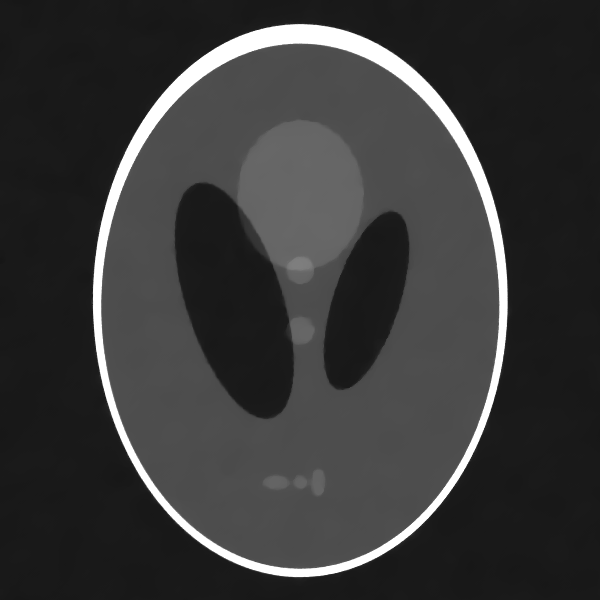

In [12]:
# test
m2i(  denoiseTV(Y, 0.9)  )

### Sum all up for Directional TV

In [17]:
def denoiseDirectionalTV(X0, beta=BETA, maxIter=1000):
    LEARNING_RATE = 0.01

    Xk = X0

    for i in range(maxIter):
        if i%1 == 0:
            print(i, tvCost(Y, Xk, beta))
            #m2i(Xk)
        Xnext = Xk - LEARNING_RATE * directionalTVCostGrad(Y, Xk, BETA)
        # init for next iteration
        if directionalTVCost(Y, Xk, beta) < directionalTVCost(Y, Xnext, beta):
            break
        Xk = Xnext
    return Xnext



0 35731.87867019669
1 32698.140055078842
2 29723.806666397224
3 26822.20320942759
4 24007.715859887157
5 21297.49260631396
6 18709.997194291984
7 16266.087445620546
8 13989.272545899168
9 11906.44532372217
10 10051.662253693443
11 8474.095621009237
12 7243.842566466194
13 6455.476935194626
14 6135.411117518503
15 6154.31737397552


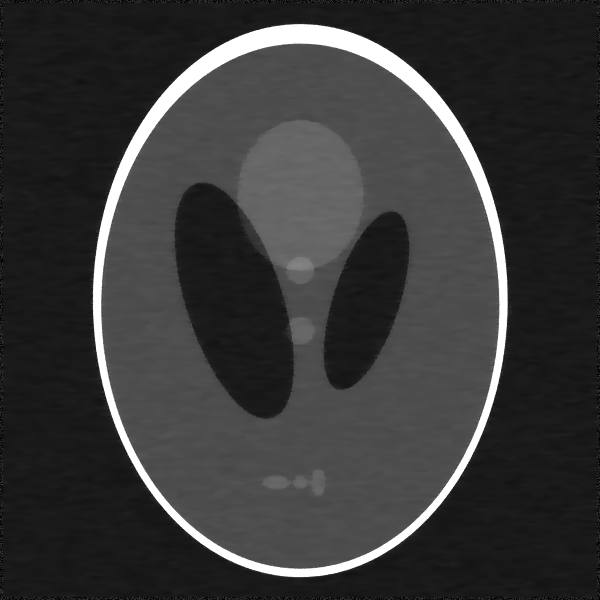

In [18]:
m2i(  denoiseDirectionalTV(Y, 0.9)  )

## 5. Results

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(231)
ax.title.set_text('Original Image')
ax.imshow(m2i(Xreal))

ax = fig.add_subplot(232)
ax.title.set_text('Noisy Image')
ax.imshow(m2i(Y))

ax = fig.add_subplot(233)
ax.title.set_text('TV B=0.3')
ax.imshow(m2i(denoiseTV(Y, 0.3)))

ax = fig.add_subplot(234)
ax.title.set_text('TV B=0.7')
ax.imshow(m2i(denoiseTV(Y, 0.7)))

ax = fig.add_subplot(235)
ax.title.set_text('TV B=0.9')
ax.imshow(m2i(denoiseTV(Y, 0.9)))

ax = fig.add_subplot(236)
ax.title.set_text('TV B=1.1')
ax.imshow(m2i(denoiseTV(Y, 1.1)))

plt.show()
plt.rcParams['figure.figsize'] = [16, 10]
